In [ ]:
pip install python-mnist


In [ ]:
!unzip /content/drive/MyDrive/f_mnist_dataset.zip

Archive:  /content/drive/MyDrive/f_mnist_dataset.zip
replace dataset/t10k-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import sys
import time
import numpy as np
import pandas as pd
import pickle
from sklearn import model_selection, svm, preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import auc
from mnist import MNIST
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import collections

In [ ]:
# Load MNIST Data
print('\nLoading MNIST Data...')
data = MNIST('./dataset/')


Loading MNIST Data...


In [ ]:
print('\nLoading Training Data...')
img_train, labels_train = data.load_training()

print('\nLoading Testing Data...')
img_test, labels_test = data.load_testing()



Loading Training Data...

Loading Testing Data...


In [ ]:
f_mnist_org_train_df = pd.DataFrame({"labels":labels_train,"images":img_train})
f_mnist_org_test_df = pd.DataFrame({"labels":labels_test,"images":img_test})

In [ ]:
f_mnist_test_df = f_mnist_org_test_df[(f_mnist_org_test_df["labels"] == 2) ]
f_mnist_test_df = f_mnist_test_df.append(f_mnist_org_test_df[f_mnist_org_test_df["labels"] == 4])

test_img = np.array(list(f_mnist_test_df["images"].values)) / 255
test_labels = np.array(list(f_mnist_test_df["labels"].values))

test_labels = np.where(test_labels == 2, 0, 1)

In [ ]:
def confusionMatrix(act, scr, thres, p_l=1):
    pred_test_labels = np.where(scr > thres,1,0)
    con_mat = np.zeros((2,2))
    for i in range(len(act)):
      con_mat[act[i]][pred_test_labels[i]] += 1

    conf_mat = ConfusionMatrix(con_mat[1][1], con_mat[0][1], con_mat[0][0], con_mat[1][0])
    return conf_mat

In [ ]:
def tpr_fn(conf_mtrx):
  if (conf_mtrx.tp + conf_mtrx.fn ) > 0 :
    return (conf_mtrx.tp ) / (conf_mtrx.tp + conf_mtrx.fn )
  else :
    return 0

def tnr_fn(conf_mtrx):
  if (conf_mtrx.tn + conf_mtrx.fp ) > 0:
    return (conf_mtrx.tn ) / (conf_mtrx.tn + conf_mtrx.fp )
  else:
    return 0

def fpr_fn(conf_mtrx):
  if (conf_mtrx.fp + conf_mtrx.tn ) > 0 :
    return (conf_mtrx.fp ) / (conf_mtrx.fp + conf_mtrx.tn )
  else :
    return 0

def fnr_fn(conf_mtrx):
  if (conf_mtrx.fn + conf_mtrx.tn ) > 0 :
    return (conf_mtrx.fn ) / (conf_mtrx.fn + conf_mtrx.tn )
  else :
    return 0

def ACC_fn(conf_mtrx):
    return (conf_mtrx.tp + conf_mtrx.tn) / (conf_mtrx.fp + conf_mtrx.tn + conf_mtrx.tp + conf_mtrx.fn)

def precision_fn(conf_mtrx):
  if (conf_mtrx.fp + conf_mtrx.tp) > 0:
    return (conf_mtrx.tp ) / (conf_mtrx.fp + conf_mtrx.tp)
  else :
    return 0

def recall_fn(conf_mtrx):
  if (conf_mtrx.fn + conf_mtrx.tp) > 0:
    return (conf_mtrx.tp ) / (conf_mtrx.fn + conf_mtrx.tp)
  else:
    return 0

def EER_fn(mean_tpr, mean_fpr):
  mean_fnr = 1- mean_tpr
  diff = np.abs(mean_fpr - mean_fnr)
  index = np.argmin(diff)
  eer = np.mean((mean_fpr[index], mean_fnr[index]))
  return eer, index

In [ ]:
evl_auc_ls = []
test_auc_ls = []
tpr_ls_itr , tnr_ls_itr, fpr_ls_itr, fnr_ls_itr, acc_ls_itr, prec_ls_itr, rec_ls_itr = ([] for i in range(7))
thresholds = np.arange(0.1,1,.1)
con_mat_ls = []
ConfusionMatrix = collections.namedtuple('conf', ['tp','fp','tn','fn']) 

In [ ]:
for i in range(0,1500,500):
  f_mnist_train_df = f_mnist_org_train_df[(f_mnist_org_train_df["labels"] == 2) ]
  f_mnist_train_df = f_mnist_train_df.append(f_mnist_org_train_df[f_mnist_org_train_df["labels"] == 4][i:i+500])


  train_img = list(f_mnist_train_df["images"].values)
  train_labels = list(f_mnist_train_df["labels"].values)

  train_img = np.array(train_img) / 255.0
  train_labels = np.array(train_labels)

  train_labels  = np.where(train_labels == 2, 0, 1)


  #Features
  X = train_img
  #Labels
  y = train_labels

  # Prepare Classifier Training and Testing Data
  print('\nPreparing Classifier Training and Validation Data...')
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.1)


  print('\nSVM Classifier with gamma = 0.1; Kernel = linear')
  clf = svm.SVC(C =1, gamma=.1, kernel='linear', probability=True)
  clf.fit(X_train,y_train)

  print('\nMaking Predictions on Validation Data...')
  y_pred = clf.predict(X_test)


  print('\nCalculating Accuracy of Predictions...')
  evl_acc = accuracy_score(y_test, y_pred)
  evl_auc_ls.append(evl_acc)



  print('\nMaking Predictions on Test Input Images...')
  test_labels_pred = clf.predict(test_img)
  test_labels_pred_prob = clf.predict_proba(test_img)


  print('\nCalculating Accuracy of Trained Classifier on Test Data... ')
  tst_acc = accuracy_score(test_labels,test_labels_pred)
  test_auc_ls.append(tst_acc)


  #score = model_selection.cross_val_score(clf,test_img,test_labels,cv= 10)
  con_mat_ls.append(confusion_matrix(test_labels,test_labels_pred))


  test_labels_pred_prob = test_labels_pred_prob[:, 1]

  tpr_ls , tnr_ls, fpr_ls, fnr_ls, acc_ls, prec_ls, rec_ls = ([] for i in range(7))

  
  for thres in thresholds:
    con_mat = confusionMatrix(test_labels,test_labels_pred_prob,thres = thres)
    print(con_mat)
    tpr_ls.append(tpr_fn(con_mat))
    tnr_ls.append(tnr_fn(con_mat))
    fpr_ls.append(fpr_fn(con_mat))
    fnr_ls.append(fnr_fn(con_mat))
    acc_ls.append(ACC_fn(con_mat))
    prec_ls.append(precision_fn(con_mat))
    rec_ls.append(recall_fn(con_mat))
  


  tpr_ls_itr.append(tpr_ls)
  tnr_ls_itr.append(tnr_ls)
  fpr_ls_itr.append(fpr_ls)
  fnr_ls_itr.append(fnr_ls)
  acc_ls_itr.append(acc_ls)
  prec_ls_itr.append(prec_ls)
  rec_ls_itr.append(rec_ls)



Preparing Classifier Training and Validation Data...

SVM Classifier with gamma = 0.1; Kernel = linear

Making Predictions on Validation Data...

Calculating Accuracy of Predictions...

Making Predictions on Test Input Images...

Calculating Accuracy of Trained Classifier on Test Data... 
conf(tp=807.0, fp=127.0, tn=873.0, fn=193.0)
conf(tp=653.0, fp=49.0, tn=951.0, fn=347.0)
conf(tp=538.0, fp=23.0, tn=977.0, fn=462.0)
conf(tp=435.0, fp=15.0, tn=985.0, fn=565.0)
conf(tp=342.0, fp=9.0, tn=991.0, fn=658.0)
conf(tp=261.0, fp=4.0, tn=996.0, fn=739.0)
conf(tp=191.0, fp=3.0, tn=997.0, fn=809.0)
conf(tp=109.0, fp=3.0, tn=997.0, fn=891.0)
conf(tp=53.0, fp=0.0, tn=1000.0, fn=947.0)

Preparing Classifier Training and Validation Data...

SVM Classifier with gamma = 0.1; Kernel = linear

Making Predictions on Validation Data...

Calculating Accuracy of Predictions...

Making Predictions on Test Input Images...

Calculating Accuracy of Trained Classifier on Test Data... 
conf(tp=808.0, fp=129.0, t

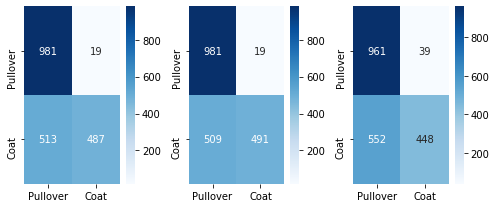

In [ ]:
class_names = ['Pullover','Coat']
plt.figure(figsize=(7,3))
plt.subplot(1,3,1)
con_mat_df = pd.DataFrame(con_mat_ls[0], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='Blues')
plt.subplot(1,3,2)
con_mat_df = pd.DataFrame(con_mat_ls[1], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='Blues')
plt.subplot(1,3,3)
con_mat_df = pd.DataFrame(con_mat_ls[2], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='Blues')
plt.tight_layout()

In [ ]:
mean_tpr = np.mean(tpr_ls_itr, axis=0)
mean_fpr = np.mean(fpr_ls_itr,axis=0)
mean_prec = np.mean(prec_ls_itr, axis=0)
mean_rec = np.mean(rec_ls_itr, axis=0)
std_tpr = np.std(tpr_ls_itr, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

In [ ]:
print("SVM Accuracy run wise", test_auc_ls)
print("Testing Performance")
print("mean", "%.4f"%np.mean(test_auc_ls))
print("standard devation", "%.4f"%np.std(test_auc_ls))

SVM Accuracy run wise [0.734, 0.736, 0.7045]
Testing Performance
mean 0.7248
standard devation 0.0144


In [ ]:
print("threshold ",thresholds)
print("mean fpr ",mean_fpr)
print("mean tpr ",mean_tpr)

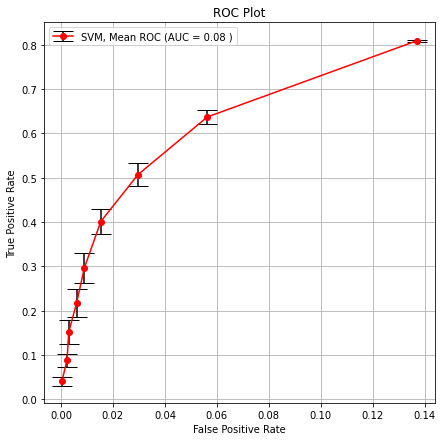

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(mean_fpr, mean_tpr,yerr = std_tpr, fmt='-o', color='r', ecolor='black', capsize=10, label=r'SVM, Mean ROC (AUC = %0.2f )' % (mean_auc))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
plt.grid()
# Show plot
plt.show()

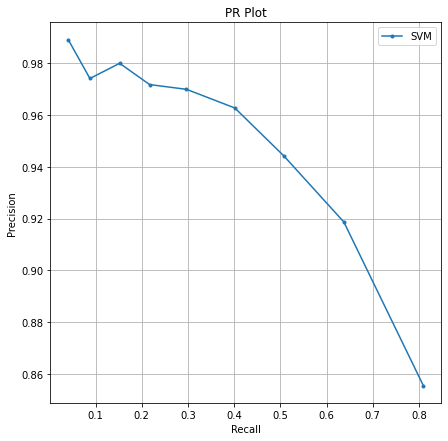

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(mean_rec, mean_prec, marker='.', label='SVM')

# Title
plt.title('PR Plot')
# Axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Show legend
plt.legend() #
plt.grid() 
# Show plot
plt.show()

In [ ]:
eer, index = EER_fn(mean_tpr, mean_fpr)

In [ ]:
print("Equal Error Rate in neural network with threshold")
print("EER",'%.4f'%eer)
print("threshold", thresholds[index])

Equal Error Rate in neural network with threshold
EER 0.1638
threshold 0.1


**Neural Network Classification**


In [ ]:
nn_test_auc_ls = []
con_mat_ls = []
tpr_ls_itr , tnr_ls_itr, fpr_ls_itr, fnr_ls_itr, acc_ls_itr, prec_ls_itr, rec_ls_itr = ([] for i in range(7))

In [ ]:
for i in range(0,1500,500):
  f_mnist_train_df = f_mnist_org_train_df[(f_mnist_org_train_df["labels"] == 2) ]
  f_mnist_train_df = f_mnist_train_df.append(f_mnist_org_train_df[f_mnist_org_train_df["labels"] == 4][i:i+500])


  train_img = list(f_mnist_train_df["images"].values)
  train_labels = list(f_mnist_train_df["labels"].values)

  train_img = np.array(train_img) / 255.0
  train_labels = np.array(train_labels)

  train_labels  = np.where(train_labels == 2, 0, 1)


  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(train_img, train_labels, epochs=50,callbacks=[callback])

  
  test_loss, test_acc = model.evaluate(test_img, test_labels)
  nn_test_auc_ls.append(test_acc)

  

  test_labels_pred_prob = model.predict(test_img)
  test_labels_pred = model.predict_classes(test_img)

  con_mat_ls.append(confusion_matrix(test_labels,test_labels_pred))

  tpr_ls , tnr_ls, fpr_ls, fnr_ls, acc_ls, prec_ls, rec_ls = ([] for i in range(7))

  
  for thres in thresholds:
    con_mat = confusionMatrix(test_labels,test_labels_pred_prob,thres = thres)
    print(con_mat)
    tpr_ls.append(tpr_fn(con_mat))
    tnr_ls.append(tnr_fn(con_mat))
    fpr_ls.append(fpr_fn(con_mat))
    fnr_ls.append(fnr_fn(con_mat))
    acc_ls.append(ACC_fn(con_mat))
    prec_ls.append(precision_fn(con_mat))
    rec_ls.append(recall_fn(con_mat))


  tpr_ls_itr.append(tpr_ls)
  tnr_ls_itr.append(tnr_ls)
  fpr_ls_itr.append(fpr_ls)
  fnr_ls_itr.append(fnr_ls)
  acc_ls_itr.append(acc_ls)
  prec_ls_itr.append(prec_ls)
  rec_ls_itr.append(rec_ls)

Epoch 1/50
204/204 [==============================] - 1s 2ms/step - loss: 0.2770 - accuracy: 0.9136
Epoch 2/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9205
Epoch 3/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9323
Epoch 4/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9268
Epoch 5/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 0.9392
Epoch 6/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1416 - accuracy: 0.9383
Epoch 7/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9427
Epoch 8/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9516
Epoch 9/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9429
Epoch 10/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1117 - accuracy: 0.9545

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


conf(tp=889.0, fp=135.0, tn=865.0, fn=111.0)
conf(tp=860.0, fp=105.0, tn=895.0, fn=140.0)
conf(tp=830.0, fp=82.0, tn=918.0, fn=170.0)
conf(tp=803.0, fp=64.0, tn=936.0, fn=197.0)
conf(tp=745.0, fp=48.0, tn=952.0, fn=255.0)
conf(tp=715.0, fp=40.0, tn=960.0, fn=285.0)
conf(tp=677.0, fp=32.0, tn=968.0, fn=323.0)
conf(tp=625.0, fp=24.0, tn=976.0, fn=375.0)
conf(tp=551.0, fp=18.0, tn=982.0, fn=449.0)
Epoch 1/50
204/204 [==============================] - 1s 2ms/step - loss: 0.2664 - accuracy: 0.9246
Epoch 2/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9344
Epoch 3/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1757 - accuracy: 0.9231
Epoch 4/50
204/204 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.9377
Epoch 5/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9346
Epoch 6/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.9353
Ep

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


conf(tp=877.0, fp=134.0, tn=866.0, fn=123.0)
conf(tp=825.0, fp=82.0, tn=918.0, fn=175.0)
conf(tp=761.0, fp=54.0, tn=946.0, fn=239.0)
conf(tp=700.0, fp=40.0, tn=960.0, fn=300.0)
conf(tp=653.0, fp=28.0, tn=972.0, fn=347.0)
conf(tp=591.0, fp=17.0, tn=983.0, fn=409.0)
conf(tp=516.0, fp=12.0, tn=988.0, fn=484.0)
conf(tp=448.0, fp=8.0, tn=992.0, fn=552.0)
conf(tp=344.0, fp=5.0, tn=995.0, fn=656.0)
Epoch 1/50
204/204 [==============================] - 1s 2ms/step - loss: 0.2892 - accuracy: 0.8967
Epoch 2/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9272
Epoch 3/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1743 - accuracy: 0.9301
Epoch 4/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9301
Epoch 5/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9318
Epoch 6/50
204/204 [==============================] - 0s 2ms/step - loss: 0.1521 - accuracy: 0.9345
Epoch

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


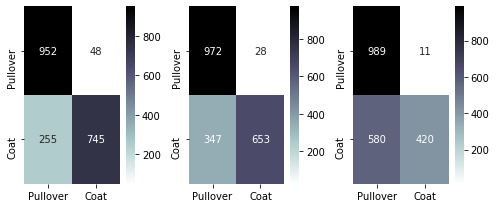

In [ ]:
class_names = ['Pullover','Coat']
plt.figure(figsize=(7,3))
plt.subplot(1,3,1)
con_mat_df = pd.DataFrame(con_mat_ls[0], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='bone_r')
plt.subplot(1,3,2)
con_mat_df = pd.DataFrame(con_mat_ls[1], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='bone_r')
plt.subplot(1,3,3)
con_mat_df = pd.DataFrame(con_mat_ls[2], index = [i for i in class_names],columns = [i for i in class_names])
sns.heatmap(con_mat_df, annot=True, fmt='g',cmap='bone_r')
plt.tight_layout()

In [ ]:
mean_tpr = np.mean(tpr_ls_itr, axis=0)
mean_fpr = np.mean(fpr_ls_itr,axis=0)
mean_prec = np.mean(prec_ls_itr, axis=0)
mean_rec = np.mean(rec_ls_itr, axis=0)
std_tpr = np.std(tpr_ls_itr, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

In [ ]:
print("Neural Network Accuracy run wise", nn_test_auc_ls)
print("Testing Performance")
print("mean", "%.4f"%np.mean(nn_test_auc_ls))
print("standard devation", "%.4f"%np.std(nn_test_auc_ls))

Neural Network Accuracy run wise [0.8485000133514404, 0.8125, 0.7045000195503235]
Testing Performance
mean 0.7885
standard devation 0.0612


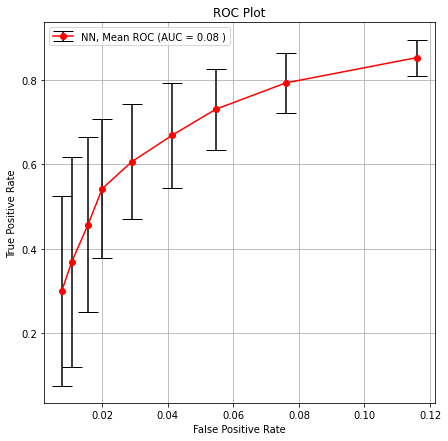

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(mean_fpr, mean_tpr,yerr = std_tpr, fmt='-o', color='r', ecolor='black', capsize=10, label=r'NN, Mean ROC (AUC = %0.2f )' % (mean_auc))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
plt.grid()
# Show plot
plt.show()

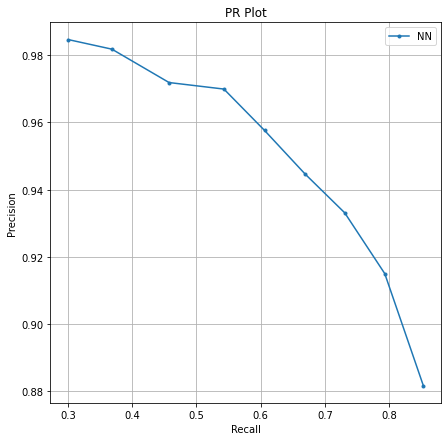

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(mean_rec, mean_prec, marker='.', label='NN')

# Title
plt.title('PR Plot')
# Axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Show legend
plt.legend() #
plt.grid() 
# Show plot
plt.show()

In [ ]:
eer, index = EER_fn(mean_tpr, mean_fpr)

In [ ]:
print("Equal Error Rate in neural network with threshold")
print("EER",'%.4f'%eer)
print("threshold", thresholds[index])

Equal Error Rate in neural network with threshold
EER 0.1315
threshold 0.1


In [ ]:
print("threshold ",thresholds)
print("mean fpr ",mean_fpr)
print("mean tpr ",mean_tpr)

threshold  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
mean fpr  [0.116      0.076      0.05466667 0.04133333 0.029      0.02
 0.01566667 0.01066667 0.00766667]
mean tpr  [0.853      0.793      0.73066667 0.669      0.606      0.54266667
 0.45733333 0.36833333 0.30033333]
